## Notebook for formatting data frames for location with Hypoinverse
Source:
- https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file
- https://www.usgs.gov/software/hypoinverse-earthquake-location
- https://chatgpt.com/c/67491af9-aaf8-800c-82e9-1033e094d8d0
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JB014966

In [2]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pnwstore.mseed import WaveformClient
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.clients.fdsn import Client
from tqdm import tqdm
import datetime 






### 1.3 Create a CSV file for picks for the association

### Format the files for HypoInverse and HypoDD
References: https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file

### Format the station files 

In [3]:
region = 'pnsn_sor'
df = pd.read_csv(f'../data/datasets_{region}/all_picks_all_years_for_assoc_{region}.csv',index_col=0)


In [4]:
TOFB = df[df['station_code']=='TOFB']

In [5]:
TOFB['station_network_code'].unique()

array([], dtype=object)

In [6]:
from obspy import read_inventory
from collections import defaultdict
import pandas as pd

client2 = Client("IRIS")
networks = pd.read_csv("../data/networks.csv")
networks = ','.join(list(networks['networks']))
starttime = UTCDateTime(year=2011, month=1, day=1)
endtime = UTCDateTime(year=2016, month=1, day=1)
inv = [] 
# inv = read_inventory("./stations/*.xml")
station_locs = defaultdict(dict)
# stations=inv


for station in df['station_code'].unique():
    inv += client2.get_stations(network=networks,
                                    station=station, channel="?H?", 
                                    starttime=starttime, endtime=endtime, level="response")
stations=inv

print(len(stations))

for network in stations:
    print(network)
    for station in network:
        print(station)
        has_HH = bool(station.select(channel="HH?"))
        has_BH = bool(station.select(channel="BH?"))

        # Apply selection logic based on channel presence
        if has_HH and has_BH:
            # If both HH and BH channels are present, select only HH
            selected_station = station.select(channel="HH?")
        elif has_HH:
            # If only HH channels are present
            selected_station = station.select(channel="HH?")
        elif has_BH:
            # If only BH channels are present
            selected_station = station.select(channel="BH?")

        for chn in selected_station:
            print('This is chn: ', chn)
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict
            if station_locs[sid]["component"]=='Z':
                station_locs[sid]["response"]= f"0,0,"+station_locs[sid]["response"]
            elif station_locs[sid]["component"]=='N,Z':
                station_locs[sid]["response"]= f"0,"+station_locs[sid]["response"]
station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["id"] = station_locs.index
station_locs = station_locs.rename_axis('station').reset_index()
station_locs.to_csv(f"./stations_{region}.csv",sep='\t')
station_locs

9
Network NC (USGS Northern California Network (NCSN))
	Station Count: 1/1205 (Selected/Total)
	1966-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			NC.KBO (Bosley Butte)
		Channels (6):
			NC.KBO..HHZ (2x), NC.KBO..HHN (2x), NC.KBO..HHE (2x)
Station KBO (Bosley Butte)
	Station Code: KBO
	Channel Count: 6/84 (Selected/Total)
	2001-08-29T20:00:00.000000Z - 2020-06-25T16:54:00.000000Z
	Access: open 
	Latitude: 42.2124, Longitude: -124.2260, Elevation: 1010.0 m
	Available Channels:
	    ..HH[ZNE]   100.0 Hz  2013-08-13 to 2017-05-03
	    ..HH[ZNE]   100.0 Hz  2010-11-04 to 2013-08-13

This is chn:  Channel 'HHE', Location '' 
	Time range: 2010-11-04T20:00:00.000000Z - 2013-08-13T18:11:00.000000Z
	Latitude: 42.2124, Longitude: -124.2260, Elevation: 1010.0 m, Local Depth: 0.0 m
	Azimuth: 90.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 100.00 Hz
	Sensor (Description): None (CMG-3ESPC,V

,station,longitude,latitude,elevation(m),component,response,unit,id
0,NC.KBO..HH,-124.225983,42.212357,1010.0,"E,E,N,N,Z,Z","599998000.00,599998000.00,599998000.00,5999980...",m/s,NC.KBO..HH
1,NC.KEB..HH,-124.334251,42.872211,818.0,"E,E,N,N,Z,Z","1176470000.00,1176470000.00,1176470000.00,1176...",m/s,NC.KEB..HH
2,NC.KSXB..HH,-123.876884,41.830379,1136.0,"E,N,Z","1176470000.00,1176470000.00,1176470000.00",m/s,NC.KSXB..HH
3,UO.DBO..BH,-123.244423,43.118721,957.0,"E,E,N,N,Z,Z","1048768000.00,754954800.00,1048768000.00,75495...",m/s,UO.DBO..BH
4,TA.K02D..HH,-123.665398,42.695499,989.0,"E,N,Z","502116000.00,502116000.00,502116000.00",m/s,TA.K02D..HH
5,TA.J01D..BH,-123.931396,43.161400,131.0,"E,N,Z","502065000.00,502065000.00,502065000.00",m/s,TA.J01D..BH
6,TA.L02D..HH,-123.603104,42.157799,458.0,"E,N,Z","502116000.00,502116000.00,502116000.00",m/s,TA.L02D..HH
7,TA.L02E..HH,-123.602898,42.158001,454.0,"E,N,Z","502116000.00,502116000.00,502116000.00",m/s,TA.L02E..HH
8,TA.J01E..HH,-123.931396,43.161499,128.0,"E,N,Z","502116000.00,502116000.00,502116000.00",m/s,TA.J01E..HH


### Convert the station file from a CSV file to dat files

In [7]:
stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")
converted_hypoinverse = []
converted_hypoDD = {}

for i in tqdm(range(len(stations))):

    network_code, station_code, comp_code, channel_code = stations.iloc[i]['station'].split('.')
    station_weight = " "
    lat_degree = int(stations.iloc[i]['latitude'])
    lat_minute = (stations.iloc[i]['latitude'] - lat_degree) * 60
    north = "N" if lat_degree >= 0 else "S"
    lng_degree = int(stations.iloc[i]['longitude'])
    lng_minute = (stations.iloc[i]['longitude'] - lng_degree) * 60
    west = "W" if lng_degree <= 0 else "E"
    elevation = stations.iloc[i]['elevation(m)']
    line_hypoinverse = f"{station_code:<5} {network_code:<2} {comp_code[:-1]:<1}{channel_code:<3} {station_weight}{abs(lat_degree):2.0f} {abs(lat_minute):7.4f}{north}{abs(lng_degree):3.0f} {abs(lng_minute):7.4f}{west}{elevation:4.0f}\n"
    converted_hypoinverse.append(line_hypoinverse)
    converted_hypoDD[f"{station_code}"] = f"{network_code:<2}{station_code:<5} {stations.iloc[i]['latitude']:.3f} {stations.iloc[i]['longitude']:.3f} {elevation:4.0f}\n"

out_file = f'stations_hypoinverse_{region}.dat'
with open(out_file, 'w') as f:
    f.writelines(converted_hypoinverse)

out_file = f'stations_hypoDD_{region}.dat'
with open(out_file, 'w') as f:
    for k, v in converted_hypoDD.items():
        f.write(v)

100%|██████████| 9/9 [00:00<00:00, 5112.23it/s]


### Format the pick files

In [8]:
# Load necessary files
# Load all event data into a list of DataFrames
import datetime 
pick_assignment_files = [
    f'../data/datasets_{region}/all_pick_assignments_{region}.csv'
]

# Read all event files into DataFrames
dfs = [pd.read_csv(file, index_col=0) for file in pick_assignment_files]

# Concatenate all DataFrames into a single DataFrame
assignments =  pd.concat(dfs)

assignments = assignments.rename(columns={"time": "origin_time"})
assignments['origin_time'] = pd.to_datetime(assignments['origin_time'], utc = True)
assignments["pick_time"] = assignments["time_pick"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
assignments = assignments.sort_values(by='origin_time').reset_index(drop=True)

# Reset the idx column so that each group with the same 'time' has a new numbered event index
assignments['idx'] = assignments.groupby('origin_time').ngroup()


# picks = pd.read_csv(f'../data/datasets_{region}/all_picks_all_years_for_assoc_{region}.csv',index_col=0)
# picks = picks.sort_values(by='trace_start_time').reset_index(drop=True)


In [9]:
assignments

,idx,origin_time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,pick_id,pick_time
0,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,403,0.185083,K02D,P,1.293879e+09,4476,2011-01-01 10:45:02.699998+00:00
1,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,352517,-0.305899,K02D,S,1.293879e+09,4442,2011-01-01 10:45:29.624998+00:00
2,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,207,-0.129411,KSXB,P,1.293879e+09,1776,2011-01-01 10:44:49.757700+00:00
3,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,352453,-0.520579,KSXB,S,1.293879e+09,1783,2011-01-01 10:45:07.537700+00:00
4,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,411,0.302689,L02D,P,1.293879e+09,4501,2011-01-01 10:44:55.599998+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16534,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,352279,0.090737,L02E,P,1.451555e+09,23569054,2015-12-31 09:46:50.860000+00:00
16535,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,352365,-0.319034,KBO,P,1.451555e+09,23570205,2015-12-31 09:46:48.280000+00:00
16536,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,352305,-0.005921,K02D,P,1.451555e+09,23569345,2015-12-31 09:46:58.390000+00:00
16537,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,533682,0.099454,KBO,S,1.451555e+09,23570150,2015-12-31 09:46:57.370000+00:00


In [13]:
# Merge the picks and assignments DataFrames on the pick_id column

# Convert the datetime columns to datetime objects
# picks['trace_p_arrival'] = pd.to_datetime(picks['trace_p_arrival'])
# picks['trace_s_arrival'] = pd.to_datetime(picks['trace_s_arrival'])
assignments['pick_time'] = pd.to_datetime(assignments['pick_time'])

# picks = pd.merge(picks, assignments, left_on="pick_id", right_on="pick_id", how='left')

# # Fill NaN values and convert idx columns to integers
# picks = picks.fillna(-1).astype({'idx': int})

# # Rename columns for consistency
# picks = picks.rename(columns={"station_code": "id", "pick_time": "timestamp","phase":'type','idx':'event_index'})
# picks['type'] = picks['type'].str.lower()

# Rename columns for consistency
assignments = assignments.rename(columns={"station": "id", "pick_time": "timestamp","phase":'type','idx':'event_index'})
assignments['type'] = assignments['type'].str.lower()


In [14]:
# picks.to_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t", index=False,
#                     date_format='%Y-%m-%dT%H:%M:%S.%f',
#                     columns=["id", "timestamp", "type", "event_index"])
assignments.to_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t", index=False,
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["id", "timestamp", "type", "event_index"])

In [15]:
assignments

,event_index,origin_time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,id,type,time_pick,pick_id,timestamp
0,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,403,0.185083,K02D,p,1.293879e+09,4476,2011-01-01 10:45:02.699998+00:00
1,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,352517,-0.305899,K02D,s,1.293879e+09,4442,2011-01-01 10:45:29.624998+00:00
2,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,207,-0.129411,KSXB,p,1.293879e+09,1776,2011-01-01 10:44:49.757700+00:00
3,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,352453,-0.520579,KSXB,s,1.293879e+09,1783,2011-01-01 10:45:07.537700+00:00
4,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,411,0.302689,L02D,p,1.293879e+09,4501,2011-01-01 10:44:55.599998+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16534,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,352279,0.090737,L02E,p,1.451555e+09,23569054,2015-12-31 09:46:50.860000+00:00
16535,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,352365,-0.319034,KBO,p,1.451555e+09,23570205,2015-12-31 09:46:48.280000+00:00
16536,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,352305,-0.005921,K02D,p,1.451555e+09,23569345,2015-12-31 09:46:58.390000+00:00
16537,2135,2015-12-31 09:46:36.747704+00:00,103.196884,-322.085565,1.171875,7,41.594114,-124.262270,1.171875,2636,533682,0.099454,KBO,s,1.451555e+09,23570150,2015-12-31 09:46:57.370000+00:00


### Format event files

In [16]:
catalog = assignments.drop_duplicates(subset='event_idx')

In [17]:
catalog = catalog.rename(columns={'origin_time':'time',"depth": "depth_km",'idx':'event_index'})


In [18]:
catalog

,event_index,time,x,y,z,picks,latitude,longitude,depth_km,event_idx,pick_idx,residual,id,type,time_pick,pick_id,timestamp
0,0,2011-01-01 10:44:25.058283+00:00,100.965600,-447.960938,6.640625,6,40.461192,-124.309615,6.640625,0,403,0.185083,K02D,p,1.293879e+09,4476,2011-01-01 10:45:02.699998+00:00
6,1,2011-01-02 06:00:27.043481+00:00,-31.795797,-433.656918,12.109375,12,40.595524,-125.875626,12.109375,1,804,0.324296,L02D,p,1.293948e+09,7770,2011-01-02 06:01:04.649998+00:00
18,2,2011-01-02 22:40:11.017906+00:00,78.652760,-447.960938,1.953125,11,40.463601,-124.572646,1.953125,2,352640,0.250801,L02D,s,1.294008e+09,7789,2011-01-02 22:41:06.124998+00:00
29,3,2011-01-03 02:24:55.148617+00:00,90.924822,-254.856673,0.390625,6,42.200770,-124.399086,0.390625,3,352795,0.404301,L02D,s,1.294022e+09,13173,2011-01-03 02:25:15.399998+00:00
35,4,2011-01-03 07:08:42.728265+00:00,237.073922,-194.779791,0.390625,8,42.710313,-122.606237,0.390625,5,1014,-0.079647,DBO,p,1.294039e+09,11659,2011-01-03 07:08:54.710000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16497,2131,2015-12-29 21:21:54.859221+00:00,70.843266,-407.909683,0.390625,12,40.824934,-124.660205,0.390625,2631,533394,-0.240543,KBO,s,1.451424e+09,23566122,2015-12-29 21:22:39.140000+00:00
16509,2132,2015-12-30 07:41:43.690372+00:00,123.278439,-159.019742,5.859375,7,43.058776,-123.986710,5.859375,2632,533605,-0.221138,J01E,s,1.451461e+09,23567727,2015-12-30 07:41:47.780000+00:00
16516,2133,2015-12-30 15:14:18.895135+00:00,85.346612,-406.479281,5.859375,9,40.836433,-124.488107,5.859375,2633,533581,0.338113,L02E,s,1.451489e+09,23567677,2015-12-30 15:15:04.080000+00:00
16525,2134,2015-12-30 17:21:56.886771+00:00,76.421476,-173.323761,19.140625,7,42.936197,-124.563756,19.140625,2634,352171,0.059669,KEB,p,1.451496e+09,23568405,2015-12-30 17:22:01.657700+00:00


In [19]:
catalog.to_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t", index=False,
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "longitude", "latitude", "depth_km",'event_index'])

In [20]:
events = pd.read_csv(f'../data/datasets_nwa_shelf_trench/events_nwa_shelf_trench.csv', index_col=0)
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2011-01-02 02:10:45.481987+00:00,19.523735,523.281993,49.609375,10,49.206819,-125.232068,49.609375
8,8,2011-01-03 22:30:53.445832+00:00,-78.652760,277.252856,12.890625,6,46.989816,-126.533950,12.890625
10,10,2011-01-05 05:25:45.145580+00:00,-97.618674,461.774708,4.296875,6,48.646430,-126.824766,4.296875
11,11,2011-01-05 09:29:58.041704+00:00,-92.040464,551.890032,24.609375,7,49.457391,-126.769550,24.609375
12,12,2011-01-05 14:35:15.536295+00:00,-290.624737,559.042042,5.078125,6,49.459134,-129.509297,5.078125
...,...,...,...,...,...,...,...,...,...
266,266,2014-05-04 09:37:25.896488+00:00,-306.243725,507.547571,13.671875,6,48.989699,-129.684922,13.671875
273,273,2014-05-21 04:04:16.795543+00:00,-77.537118,533.294806,41.796875,10,49.292245,-126.565918,41.796875
275,275,2014-05-25 11:21:40.359990+00:00,232.611354,414.571444,49.609375,7,48.186967,-122.371453,49.609375
276,276,2014-05-27 08:51:10.491000+00:00,-285.046527,507.547571,11.328125,8,48.999834,-129.395983,11.328125


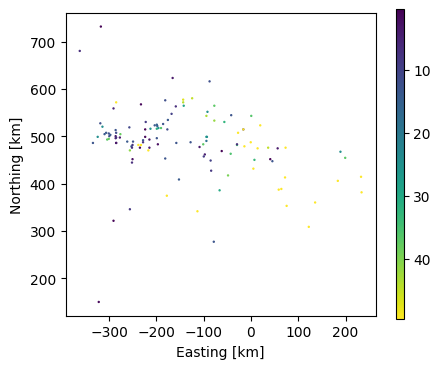

In [21]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],s=0.5,cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

In [22]:
catalog = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv',index_col=0)
len(catalog)

2136

In [23]:
from datetime import datetime


stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")
stations['net'] = stations['station'].apply(lambda x: x.split('.')[0])
stations['sta'] = stations['station'].apply(lambda x: x.split('.')[1])
stations['cha'] = stations['station'].apply(lambda x: x.split('.')[3])

picks = pd.read_csv(f'../data/datasets_{region}/picks_hypoinverse_{region}.csv', sep="\t")
events = pd.read_csv(f'../data/datasets_{region}/catalog_hypoinverse_{region}.csv', sep="\t")

events["match_id"] = events["event_index"]
picks["match_id"] = picks["event_index"]
events.sort_values(by="time", inplace=True, ignore_index=True)

out_file = open(f"../hypoInv/hypoInput_{region}.arc", "w")

events['time'] = pd.to_datetime(events['time'])

picks_by_event = picks.groupby("match_id").groups
for i in tqdm(range(len(events))):

    event = events.iloc[i]
    event_time = event["time"].strftime("%Y%m%d%H%M%S%f")[:-4]
    lat_degree = int(event["latitude"])
    lat_minute = (event["latitude"] - lat_degree) * 60 * 100
    south = "S" if lat_degree <= 0 else " "
    lng_degree = int(event["longitude"])
    lng_minute = (event["longitude"] - lng_degree) * 60 * 100
    east = "E" if lng_degree >= 0 else " "
    depth = event["depth_km"]
    if np.sum(picks[picks["event_index"] == events.iloc[i]['match_id']]['type'] == 'p') == 0:
        continue
    event_line = f"{event_time}{abs(lat_degree):2d}{south}{abs(lat_minute):4.0f}{abs(lng_degree):3d}{east}{abs(lng_minute):4.0f}{depth:5.0f}"
    out_file.write(event_line + "\n")

    picks_idx = picks_by_event[event["match_id"]]
    for j in picks_idx:
        pick = picks.iloc[j]
        station_code = pick['id']
        network_code = stations['net'][stations['sta'] == pick['id']].iloc[0]
        comp_code = ''
        channel_code = stations['cha'][stations['sta'] == pick['id']].iloc[0]
        phase_type = pick['type']
        
        # Check if 'prob' column exists
        if 'prob' in pick:
            phase_weight = min(max(int((1 - pick['prob']) / (1 - 0.3) * 4) - 1, 0), 3)
        else:
            phase_weight = 0  # Default value if 'prob' column is missing
        # 2011-01-02 02:11:06.849100+00:00
        # Assuming pick['timestamp'] has the format '2012-01-01 03:19:00.689664+00:00'
        try:
            pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S.%f")  # Handle timezone with %z
        except:
            pick_time = datetime.strptime(pick["timestamp"], "%Y-%m-%dT%H:%M:%S%z")  # Handle timezone with %z
        phase_time_minute = pick_time.strftime("%Y%m%d%H%M")  # Extract YYYYMMDDHHMM
        phase_time_second = pick_time.strftime("%S%f")[:-4]  # Extract seconds with first two digits of microseconds
        tmp_line = f"{station_code:<5}{network_code:<2} {comp_code:<1}{channel_code:<3}"
        if phase_type.upper() == 'P':
            pick_line = f"{tmp_line:<13} P {phase_weight:<1d}{phase_time_minute} {phase_time_second}"
        elif phase_type.upper() == 'S':
            pick_line = f"{tmp_line:<13}   4{phase_time_minute} {'':<12}{phase_time_second} S {phase_weight:<1d}"
        else:
            raise ValueError(f"Phase type error {phase_type}")
        out_file.write(pick_line + "\n")

    out_file.write("\n")
    if i > 1e5:
        break

out_file.close()

  0%|          | 0/2136 [00:00<?, ?it/s]

100%|██████████| 2136/2136 [00:03<00:00, 586.22it/s]
